In [ ]:
import os 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
store_sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sales_forecast_train.csv')

In [ ]:
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


check for null values in the dataset 

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
store_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
store_sales = store_sales.drop(['store', 'item'], axis = 1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Converting date from object to dateTime datatype 

In [ ]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting date to Month period and then sum the number of items in each month 

In [ ]:
store_sales['date'] =store_sales['date'].dt.to_period("M")

In [ ]:
monthly_sales = store_sales.groupby('date').sum().reset_index()

Convert the resulting date column to timestamp datatype

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


Visualization

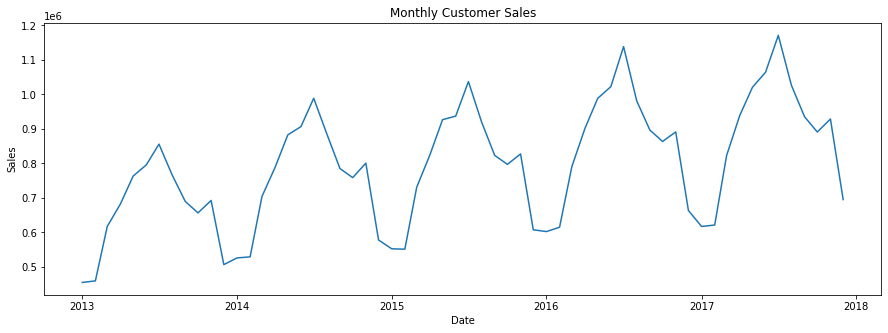

In [ ]:
figsize = (15,5)
plt.figure(figsize = figsize)
plt.plot(monthly_sales['date'],monthly_sales['sales'] )
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

Call the difference on the sales columns to make the data stationary 

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


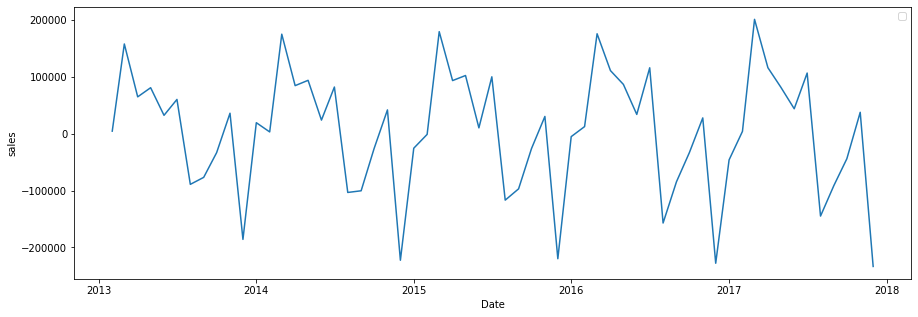

In [ ]:
figsize = (15,5)
plt.figure(figsize=figsize)
#plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'] )
plt.xlabel('Date')
plt.ylabel('sales')
plt.legend()
plt.show()


Dropping off sale and date 

In [ ]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)

preparing supervised data

In [ ]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)

supervised_data.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


split the data into Train and Test

In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [ ]:
print('Train Data Shape: ', train_data.shape)

Train Data Shape:  (35, 13)


In [ ]:
print('Test Data Shape: ', test_data.shape)

Test Data Shape:  (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]

In [ ]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
print('X_train Data Shape: ', X_train.shape)
print('y_train Data Shape: ', y_train.shape)
print('X_test Data Shape: ', X_test.shape)
print('y_test Data Shape: ', y_test.shape)

X_train Data Shape:  (35, 12)
y_train Data Shape:  (35,)
X_test Data Shape:  (12, 12)
y_test Data Shape:  (12,)


Make prediction dataframe to merge the predicted sales prices of all trained algs 

In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create the linear regression model, and predict output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
#This is a set matrix - contains the input features of the test data and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre,X_test], axis = 1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list= []
for index in range (0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name = 'Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)


In [ ]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [ ]:
Lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
Lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
Lr_r2 = r2

print('Linear Regression MSE: ', Lr_mse)
print('Linear Regression MAE: ', Lr_mae)
print('Linear Regression R2: ', Lr_r2)


Linear Regression MSE:  16221.272385416898
Linear Regression MAE:  12433.184266490765
Linear Regression R2:  0.9906152516380968


Visualization of the prediction against the actual sales 

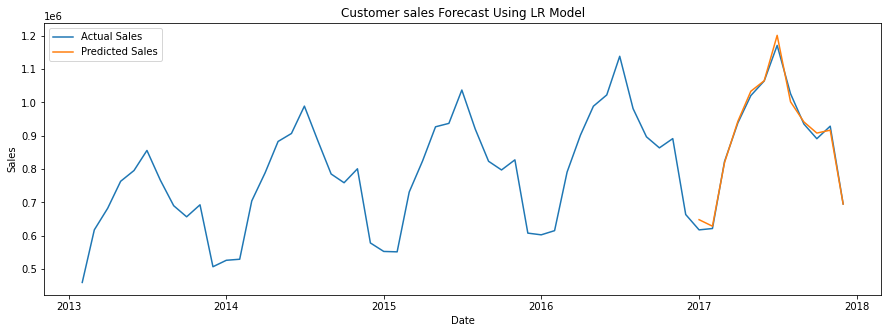

In [ ]:
plt.figure(figsize = (15,5))
#Actual sales 
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales 
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title('Customer sales Forecast Using LR Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])

plt.show()